In [1]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d

module_dir = os.path.abspath('../../src')  # Adjust path as needed
sys.path.append(module_dir)

from parser_fun import merge_hdfs_multi
from plot_functions import auto_plot_style
from plot_functions import color_sequence
import plot_functions as pf
import HE_analysis_functions as afHE

import analysis_functions as af
import stats

#Can be removed later
import importlib
importlib.reload(af)
importlib.reload(stats)
#

<module 'stats' from '/Users/samuele/Documents/Postdoc/NEXT/ASpirit/src/stats.py'>

In [2]:
krmap = pd.read_hdf('GML_krmap_combined_antes.map3d', "/krmap")

In [3]:
krmap

,z,x,y,level_3,factor,n
0,0.0,-495.0,-495.0,0,0.0,0
1,0.0,-495.0,-485.0,0,0.0,0
2,0.0,-495.0,-475.0,0,0.0,0
3,0.0,-495.0,-465.0,0,0.0,0
4,0.0,-495.0,-455.0,0,0.0,0
...,...,...,...,...,...,...
119995,1500.0,495.0,455.0,0,0.0,0
119996,1500.0,495.0,465.0,0,0.0,0
119997,1500.0,495.0,475.0,0,0.0,0
119998,1500.0,495.0,485.0,0,0.0,0


In [11]:
krmap['z'].unique()

array([   0. ,   67.5,  202.5,  337.5,  472.5,  607.5,  742.5,  877.5,
       1012.5, 1147.5, 1282.5, 1500. ])

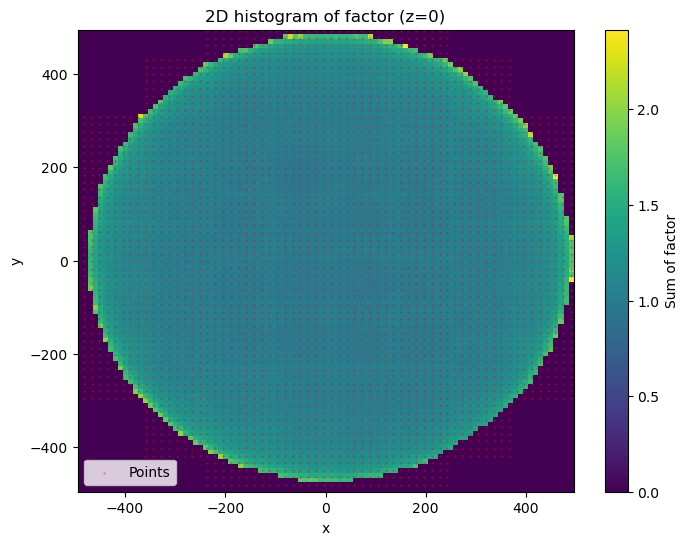

In [26]:
import matplotlib.pyplot as plt
import numpy as np

from invisible_cities.database.load_db import DataSiPM

SiPMpos = DataSiPM('next100', 0).filter('XY')
X, Y = SiPMpos["X"], SiPMpos["Y"]

# Assuming your dataframe is called df
df0 = krmap[krmap["z"] == 0]

# Define histogram bins
xbins = np.linspace(df0["x"].min(), df0["x"].max(), 100)  # adjust number of bins
ybins = np.linspace(df0["y"].min(), df0["y"].max(), 100)

# Make 2D histogram with factor as weights
H, xedges, yedges = np.histogram2d(df0["x"], df0["y"], bins=[xbins, ybins], weights=df0["factor"])

# Plot histogram
plt.figure(figsize=(8,6))
plt.pcolormesh(xedges, yedges, H.T, shading="auto")
plt.colorbar(label="Sum of factor")
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D histogram of factor (z=0)")

# Overlay scatter plot of all points (x vs y)
plt.scatter(X,Y, color="red", s=1, marker ='.', alpha=0.5, label="Points")
plt.legend()

plt.show()

In [18]:
from scipy.interpolate import RegularGridInterpolator

# Assume krmap is your DataFrame with columns: z, x, y, factor

# Step 1: extract unique sorted coordinates
x_vals = np.sort(krmap["x"].unique())
y_vals = np.sort(krmap["y"].unique())
z_vals = np.sort(krmap["z"].unique())

# ---- SCALE Z ----
# rescale z from [0, 67.5] to [0, 33.75]
z_vals_scaled = z_vals * 2

# Step 2: reshape factor values into a 3D array
nx, ny, nz = len(x_vals), len(y_vals), len(z_vals)
factor_3d = krmap.set_index(["x","y","z"]).sort_index()["factor"].values.reshape(nx, ny, nz)

# Step 3: build interpolator (use scaled z axis!)
interp = RegularGridInterpolator((x_vals, y_vals, z_vals_scaled), factor_3d,
                                 bounds_error=False, fill_value=None)

# Step 4: create refined grid (half bin size → step = 5 for x,y; rescaled z)
bin_size = x_vals[1] - x_vals[0]   # should be 10
new_step = bin_size // 2           # 5
x_new = np.arange(x_vals.min(), x_vals.max() + new_step, new_step)
y_new = np.arange(y_vals.min(), y_vals.max() + new_step, new_step)

# For z: we rescale so that it spans 33.75 instead of 67.5
z_new = np.linspace(z_vals_scaled.min(), z_vals_scaled.max(), 2*nz - 1)

xx, yy, zz = np.meshgrid(x_new, y_new, z_new, indexing="ij")
points_new = np.column_stack([xx.ravel(), yy.ravel(), zz.ravel()])

# Step 5: interpolate
factors_new = interp(points_new)

# Step 6: put back into DataFrame
krmap_refined = pd.DataFrame({
    "x": points_new[:,0],
    "y": points_new[:,1],
    "z": points_new[:,2],   # already scaled to [0, 33.75]
    "factor": factors_new
})

In [30]:
krmap_refined['z'].unique()

array([  0.        ,  34.09090909,  68.18181818, 102.27272727,
       136.36363636, 170.45454545, 204.54545455, 238.63636364,
       272.72727273, 306.81818182, 340.90909091, 375.        ,
       409.09090909, 443.18181818, 477.27272727, 511.36363636,
       545.45454545, 579.54545455, 613.63636364, 647.72727273,
       681.81818182, 715.90909091, 750.        ])